In [1]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from uuid import uuid4
from pylab import rcParams
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, classification_report
from catboost import CatBoostClassifier, FeaturesData, Pool
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
pd.options.display.float_format = '{:.2f}'.format
pd.options.mode.chained_assignment = None
rcParams['figure.figsize'] = (14, 16)
sns.set(style='white', font_scale=1.2)
np.random.seed(1)

In [2]:
'''Выводим список файлов из папки с данными'''
data_dir = os.path.join(os.getcwd(), 'Data')

print('Available files'.center(100, '-'))
print('\n'.join(os.listdir(data_dir)))

------------------------------------------Available files-------------------------------------------
orders.csv
SampleSubmission.csv
test_customers.csv
test_locations.csv
train_customers.csv
train_locations.csv
VariableDefinitions.txt
vendors.csv


In [3]:
'''Описание переменных'''
print('Variable Definitions'.center(100, '-'))
with open(os.path.join(data_dir, 'VariableDefinitions.txt'), encoding='utf-8') as VariableDefinitions:
    print(VariableDefinitions.read())

----------------------------------------Variable Definitions----------------------------------------
﻿Train Customers


Information on the customers in the training set. 


'akeed_customer_id': Unique customer ID, used in train_locations and train_orders
'gender': Customer gender
'dob': Birth Year (if entered)
'status' and 'verified': Account status
'language': Chosen language
'Created_at' and 'updated_at': dates when account was created/updated


Train Locations


Each customer orders from one or more locations. Each is assigned a location number. 
'customer_id': The unique customer ID 
'location_number': Location number (most customers have one or two)
'location_type': Home, Work, Other or NA
'Latitude' and 'longitude': Not true latitude and longitude - locations have been masked, but nearby locations remain nearby in the new reference frame and can thus be used for clustering. However, not all locations are useful due to GPS errors and missing data - you may want to treat outliers s

In [4]:
'''Разносим csv-файлы по переменным с соответствующим названием'''
data_variables = {}

for file in os.listdir(data_dir):
    file_name, file_extension = file.split('.')
    if file_extension == 'csv':
        tmp_df = pd.read_csv(os.path.join(data_dir, file), low_memory=False)
        if file_name != 'SampleSubmission':
            tmp_df.columns = tmp_df.columns.str.lower() #приводим имена всех колонок к нижнему регистру
        data_variables[file_name] = tmp_df

vars().update(data_variables)

In [5]:
'''Смотрим, как выглядит сабмит'''
print(SampleSubmission.shape)
SampleSubmission.head(3)

(1672000, 2)


,CID X LOC_NUM X VENDOR,target
0,Z59FTQD X 0 X 243,0
1,0JP29SK X 0 X 243,0
2,0JP29SK X 1 X 243,0


In [6]:
'''Функция, возвращающая информацию о количестве пропущенных значений в колонках датафрейма, если таковые имеются'''
def check_na(df):
    if not isinstance(df, pd.DataFrame):
        raise TypeError('df should be a pd.DataFrame')
    
    na_values = df.isna().sum().loc[lambda x: x > 0]
    print('Checking for NA values'.center(100, '-'))
    if na_values.index.__len__():
        display(na_values)
    else:
        print('There is no NA values')


'''Функция, печатающая размер датафрейма'''
def print_shape(df):
    if not isinstance(df, pd.DataFrame):
        raise TypeError('df should be a pd.DataFrame')
    print(f'Shape: {df.shape}')

    
'''Функция, печатающая первые строки датафрейма'''
def display_df(df, h=3):
    if not isinstance(df, pd.DataFrame):
        raise TypeError('df should be a pd.DataFrame')
    display(df.head(h))
    

'''Функция, запускающая все вышеперечисленное'''
def show_info(df, verbose=False, **kwargs):
    print_shape(df)
    check_na(df)
    display_df(df, **kwargs)
    if verbose:
        df.info()

In [7]:
'''
Смотрим на заказы, пока оставляем лишь инфу о клиенте, локации, ресторане 
Преобразуем тип данных
'''
show_info(orders)

orders_col_types = {
    'customer_id': str,
    'vendor_id': str,
    'location_number': str
}

orders = orders.filter(items=orders_col_types.keys()).astype(orders_col_types)

Shape: (135303, 26)
---------------------------------------Checking for NA values---------------------------------------


akeed_order_id                        70
item_count                          6925
promo_code                        130998
promo_code_discount_percentage     69423
is_favorite                        35195
vendor_rating                      90083
preparationtime                    55560
delivery_time                     130180
order_accepted_time                48348
driver_accepted_time               88845
ready_for_pickup_time              51054
picked_up_time                     51438
delivered_time                     49562
delivery_date                      99759
location_type                      48893
dtype: int64

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,vendor_rating,driver_rating,deliverydistance,preparationtime,delivery_time,order_accepted_time,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,location_number,location_type,cid x loc_num x vendor
0,163238.00,92PEE24,1.00,7.60,2,NaN,0.00,nan,NaN,No,nan,0.00,0.00,nan,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105
1,163240.00,QS68UD8,1.00,8.70,1,NaN,0.00,nan,NaN,No,nan,0.00,0.00,nan,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241.00,MB7VY5F,2.00,14.40,1,NaN,0.00,nan,NaN,No,nan,0.00,0.00,nan,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83


In [8]:
'''Выводим получившееся'''
show_info(orders)

Shape: (135303, 3)
---------------------------------------Checking for NA values---------------------------------------
There is no NA values


,customer_id,vendor_id,location_number
0,92PEE24,105,0
1,QS68UD8,294,0
2,MB7VY5F,83,0


In [9]:
'''Смотрим на рестики, вычленяем полезные колонки, которые не требуют доп обработки'''
show_info(vendors)

vendors_col_types = {
    'vendor_id': str,
    'latitude': np.float32,
    'longitude': np.float32,
    'vendor_category_en': str,
    'delivery_charge': np.float32,
    'serving_distance': np.float32,
    'is_open': str,
    'prepration_time': np.float32,
    'commission': np.float32,
    'is_akeed_delivering': str,
    'discount_percentage': np.float32,
    'status': str,
    'verified': str,
    'rank': np.float32,
    'language': str,
    'vendor_rating': np.float32,
    'open_close_flags': str,
    'one_click_vendor': str,
    'country_id': str,
    'city_id': str,
    'device_type': str,
    'display_orders': str
}

vendors_fillna = {# заполняем пропуски в количественных фичах средним, в категориальных - новой категорией
    col: vendors[col].median() if dtype == np.float32 else 'other' for col, dtype in vendors_col_types.items()
}

vendors = vendors.rename(columns={'id': 'vendor_id'}).\
                  filter(items=vendors_col_types.keys()).\
                  astype(vendors_col_types).\
                  fillna(vendors_fillna)

vendors = gpd.GeoDataFrame(# формируем точки долгота-широта
    vendors, 
    geometry=gpd.points_from_xy(vendors['longitude'], vendors['latitude']) 
)

Shape: (100, 59)
---------------------------------------Checking for NA values---------------------------------------


openingtime              9
openingtime2             9
commission              15
language                15
sunday_from_time1        1
sunday_to_time1          1
sunday_from_time2       58
sunday_to_time2         58
monday_from_time2       58
monday_to_time2         58
tuesday_from_time1       1
tuesday_to_time1         1
tuesday_from_time2      59
tuesday_to_time2        59
wednesday_from_time2    58
wednesday_to_time2      58
thursday_from_time1      1
thursday_to_time1        1
thursday_from_time2     58
thursday_to_time2       58
friday_from_time1        4
friday_to_time1          4
friday_from_time2       55
friday_to_time2         55
saturday_from_time1      2
saturday_to_time1        2
saturday_from_time2     58
saturday_to_time2       58
primary_tags            23
vendor_tag               3
vendor_tag_name          3
dtype: int64

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,openingtime,openingtime2,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,tuesday_from_time2,tuesday_to_time2,wednesday_from_time1,wednesday_to_time1,wednesday_from_time2,wednesday_to_time2,thursday_from_time1,thursday_to_time1,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2,primary_tags,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
0,4,118597.00,-0.59,0.75,Restaurants,2.00,0.00,6.00,1.00,11:00AM-11:30PM,-,15,0.00,Yes,0.00,1.00,1,11,EN,4.40,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,10:00:00,23:59:00,00:00:00,00:30:00,10:00:00,23:59:00,"{""primary_tags"":""4""}",1.00,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.00,1.00,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,13,118608.00,-0.47,0.74,Restaurants,2.00,0.70,5.00,1.00,08:30AM-10:30PM,-,14,0.00,Yes,0.00,1.00,1,11,EN,4.70,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,19:30:00,00:00:00,01:30:00,08:00:00,19:30:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,"{""primary_tags"":""7""}",1.00,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.00,1.00,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
2,20,118616.00,-0.41,0.64,Restaurants,2.00,0.00,8.00,1.00,08:00AM-10:45PM,-,19,0.00,Yes,0.00,1.00,1,1,EN,4.50,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,"{""primary_tags"":""71""}",1.00,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.00,1.00,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1


In [10]:
'''Функция, проверяющая является ли значение "x" выбросом в ряде "series"'''
def is_outlier(x, series, sensitivity=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    lower_bound, upper_bound = (q1 - sensitivity * (q3 - q1), q3 + sensitivity * (q3 - q1))
    return x < lower_bound or x > upper_bound

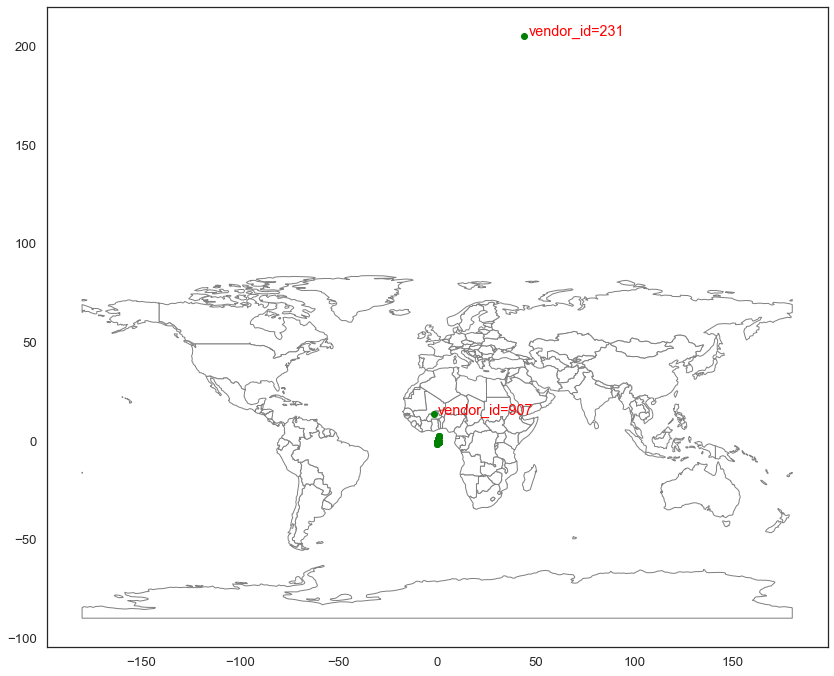

In [11]:
'''Наносим на карту рестораны, смотрим на выбросы'''
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_ax = world.plot(color='white', edgecolor='gray')
ax = vendors.plot(ax=world_ax, color='green')
for idx, (vid, longi, lati) in enumerate(vendors[['vendor_id', 'longitude', 'latitude']].apply(tuple, axis=1)):
    if is_outlier(longi, vendors['longitude'], 5) or is_outlier(lati, vendors['latitude'], 5):
        ax.annotate(f'vendor_id={int(vid)}', xy=(longi, lati), xytext=(longi + 2, lati), color='red')
plt.show()

In [12]:
vendors = vendors.drop(columns='geometry')

vendors_coords_median = vendors.query("vendor_id != ['231', '907']")[['longitude', 'latitude']].median()

vendors.loc[vendors['vendor_id'] == '907', 'longitude'] = vendors_coords_median['longitude']
vendors.loc[vendors['vendor_id'] == '907', 'latitude'] = vendors_coords_median['latitude']

vendors.loc[vendors['vendor_id'] == '231', 'longitude'] = vendors_coords_median['longitude']
vendors.loc[vendors['vendor_id'] == '231', 'latitude'] = vendors_coords_median['latitude']

show_info(vendors)

Shape: (100, 22)
---------------------------------------Checking for NA values---------------------------------------
There is no NA values


,vendor_id,latitude,longitude,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,open_close_flags,one_click_vendor,country_id,city_id,device_type,display_orders
0,4,-0.59,0.75,Restaurants,0.00,6.00,1.0,15.00,0.00,Yes,0.00,1.0,1,11.00,EN,4.40,1.0,Y,1.0,1.0,3,1
1,13,-0.47,0.74,Restaurants,0.70,5.00,1.0,14.00,0.00,Yes,0.00,1.0,1,11.00,EN,4.70,1.0,Y,1.0,1.0,3,1
2,20,-0.41,0.64,Restaurants,0.00,8.00,1.0,19.00,0.00,Yes,0.00,1.0,1,1.00,EN,4.50,1.0,Y,1.0,1.0,3,1


In [13]:
'''Смотрим на клиентов, оставляем для каждого последнюю проапдейтченную запись'''
show_info(train_customers)

customers_col_types = {
    'customer_id': str,
    'gender': str,
    'status': str,
    'verified': str,
    'language': str,
    'updated_at': 'datetime64[ns]'
}

customers_fillna = {col: 'other' for col in customers_col_types}

train_customers = train_customers.rename(columns={'akeed_customer_id': 'customer_id'}).\
                                  filter(items=customers_col_types.keys()).\
                                  astype(customers_col_types).\
                                  fillna(customers_fillna).\
                                  sort_values(by=['customer_id', 'updated_at']).\
                                  drop_duplicates(subset='customer_id', keep='last').\
                                  drop(columns='updated_at')

Shape: (34674, 8)
---------------------------------------Checking for NA values---------------------------------------


gender      12154
dob         31628
language    13575
dtype: int64

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,nan,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,Male,nan,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,Male,nan,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42


In [14]:
show_info(train_customers)

Shape: (34523, 5)
---------------------------------------Checking for NA values---------------------------------------
There is no NA values


,customer_id,gender,status,verified,language
5023,000THBA,Male,1,1,EN
10849,001XN9X,Male,1,1,EN
29977,001ZNTK,nan,1,1,nan


In [15]:
show_info(test_customers)

test_customers = test_customers.rename(columns={'akeed_customer_id': 'customer_id'}).\
                                filter(items=customers_col_types.keys()).\
                                astype(customers_col_types).\
                                fillna(customers_fillna).\
                                sort_values(by=['customer_id', 'updated_at']).\
                                drop_duplicates(subset='customer_id', keep='last').\
                                drop(columns='updated_at')

Shape: (9768, 8)
---------------------------------------Checking for NA values---------------------------------------


gender      3447
dob         8920
language    3840
dtype: int64

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,ICE2DJP,Male,nan,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36
1,FWNUI71,Male,nan,1,1,EN,2018-03-22 20:11:47,2018-03-22 20:11:47
2,LRX7BCH,Male,nan,1,1,EN,2018-04-17 20:01:15,2018-04-17 20:01:15


In [16]:
show_info(test_customers)

Shape: (9753, 5)
---------------------------------------Checking for NA values---------------------------------------
There is no NA values


,customer_id,gender,status,verified,language
1880,000IPH5,Male,1,1,EN
2390,002U0H9,Male,1,1,EN
3472,00ICGWM,Male,1,1,EN


In [17]:
'''Смотрим на локации'''
show_info(train_locations)

locations_col_types = {
    'customer_id': str,
    'location_number': str,
    'location_type': str,
    'latitude': np.float32,
    'longitude': np.float32
}

train_locations_fillna = {
    col: train_locations[col].median() if dtype == np.float32 else 'other' for col, dtype in locations_col_types.items()
}

train_locations = train_locations.astype(locations_col_types).\
                                  fillna(train_locations_fillna)

Shape: (59503, 5)
---------------------------------------Checking for NA values---------------------------------------


location_type    27209
latitude             6
longitude            6
dtype: int64

,customer_id,location_number,location_type,latitude,longitude
0,02SFNJH,0,NaN,1.68,-78.79
1,02SFNJH,1,NaN,1.68,0.77
2,02SFNJH,2,NaN,-0.50,0.66


In [18]:
train_locations_coords = train_locations[['longitude', 'latitude']]
train_locations_coords.describe()

,longitude,latitude
count,59503.00,59503.00
mean,-25.11,2.36
std,36.95,22.73
min,-134.42,-1038.15
25%,-78.52,-0.50
50%,0.02,-0.09
75%,0.51,0.26
max,45.35,453.65


In [19]:
'''Если долгота или ширина отклоняются больше чем на 3 стандартных отклонения, меняем на медиану'''
train_outlier_row = (np.abs(zscore(train_locations_coords)) > 3).any(axis=1)
train_locations_coords_median = train_locations_coords.loc[~train_outlier_row, :].median()

train_locations_coords.loc[train_outlier_row, 'longitude'] = train_locations_coords_median['longitude']
train_locations_coords.loc[train_outlier_row, 'latitude'] = train_locations_coords_median['latitude']

train_locations.loc[:, ['longitude', 'latitude']] = train_locations_coords

In [20]:
show_info(train_locations)

Shape: (59503, 5)
---------------------------------------Checking for NA values---------------------------------------
There is no NA values


,customer_id,location_number,location_type,latitude,longitude
0,02SFNJH,0,nan,1.68,-78.79
1,02SFNJH,1,nan,1.68,0.77
2,02SFNJH,2,nan,-0.50,0.66


In [21]:
show_info(test_locations)

test_locations_fillna = {
     col: test_locations[col].median() if dtype == np.float32 else 'other' for col, dtype in locations_col_types.items()
}

test_locations = test_locations.astype(locations_col_types).\
                                fillna(test_locations_fillna)

Shape: (16720, 5)
---------------------------------------Checking for NA values---------------------------------------


location_type    7650
latitude            3
longitude           3
dtype: int64

,customer_id,location_number,location_type,latitude,longitude
0,Z59FTQD,0,NaN,126.03,-9.11
1,0JP29SK,0,Home,0.28,-78.62
2,0JP29SK,1,Home,0.12,-78.61


In [22]:
test_locations_coords = test_locations[['longitude', 'latitude']]
test_locations_coords.describe()

,longitude,latitude
count,16720.00,16720.00
mean,-25.27,2.51
std,36.94,22.10
min,-132.20,-671.69
25%,-78.52,-0.51
50%,0.01,-0.10
75%,0.51,0.25
max,44.12,453.65


In [23]:
'''Если долгота или ширина отклоняются больше чем на 3 стандартных отклонения, меняем на медиан'''
test_outlier_row = (np.abs(zscore(test_locations_coords)) > 3).any(axis=1)
test_locations_coords_median = test_locations_coords.loc[~test_outlier_row, :].median()

test_locations_coords.loc[test_outlier_row, 'longitude'] = test_locations_coords_median['longitude']
test_locations_coords.loc[test_outlier_row, 'latitude'] = test_locations_coords_median['latitude']

test_locations.loc[:, ['longitude', 'latitude']] = test_locations_coords

In [24]:
show_info(test_locations)

Shape: (16720, 5)
---------------------------------------Checking for NA values---------------------------------------
There is no NA values


,customer_id,location_number,location_type,latitude,longitude
0,Z59FTQD,0,nan,-0.11,0.02
1,0JP29SK,0,Home,0.28,-78.62
2,0JP29SK,1,Home,0.12,-78.61


In [25]:
train_custloc = pd.merge(train_customers, train_locations, on='customer_id', how='right').fillna(customers_fillna)
test_custloc = pd.merge(test_customers, test_locations, on='customer_id', how='right').fillna(customers_fillna)

show_info(train_custloc)
show_info(test_custloc)

Shape: (59503, 9)
---------------------------------------Checking for NA values---------------------------------------
There is no NA values


,customer_id,gender,status,verified,language,location_number,location_type,latitude,longitude
0,000THBA,Male,1,1,EN,0,nan,-0.02,0.17
1,001XN9X,Male,1,1,EN,0,Home,0.19,-78.61
2,001ZNTK,nan,1,1,nan,0,Other,14.08,-1.61


Shape: (16720, 9)
---------------------------------------Checking for NA values---------------------------------------
There is no NA values


,customer_id,gender,status,verified,language,location_number,location_type,latitude,longitude
0,000IPH5,Male,1,1,EN,0,Home,-0.39,-78.55
1,002U0H9,Male,1,1,EN,0,Work,-1.65,-78.40
2,00ICGWM,Male,1,1,EN,0,nan,-0.12,-0.00


In [26]:
Xy_train = pd.merge(
    train_custloc.assign(key=0), 
    vendors.assign(key=0), 
    how='inner', 
    on='key',
    suffixes=('_cl', '_v')
).drop('key', axis=1).\
  merge(orders, how='left', on=['customer_id', 'location_number', 'vendor_id'], indicator=True)

X_train = Xy_train.drop(columns='_merge')
y_train = Xy_train['_merge'].map({'left_only': '0', 'both': '1'})

In [27]:
show_info(X_train, verbose=True)
print('Value counts:'.center(100, '-'), y_train.value_counts(), sep='\n')

Shape: (6005461, 31)
---------------------------------------Checking for NA values---------------------------------------
There is no NA values


,customer_id,gender,status_cl,verified_cl,language_cl,location_number,location_type,latitude_cl,longitude_cl,vendor_id,latitude_v,longitude_v,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,commission,is_akeed_delivering,discount_percentage,status_v,verified_v,rank,language_v,vendor_rating,open_close_flags,one_click_vendor,country_id,city_id,device_type,display_orders
0,000THBA,Male,1,1,EN,0,nan,-0.02,0.17,4,-0.59,0.75,Restaurants,0.00,6.00,1.0,15.00,0.00,Yes,0.00,1.0,1,11.00,EN,4.40,1.0,Y,1.0,1.0,3,1
1,000THBA,Male,1,1,EN,0,nan,-0.02,0.17,13,-0.47,0.74,Restaurants,0.70,5.00,1.0,14.00,0.00,Yes,0.00,1.0,1,11.00,EN,4.70,1.0,Y,1.0,1.0,3,1
2,000THBA,Male,1,1,EN,0,nan,-0.02,0.17,20,-0.41,0.64,Restaurants,0.00,8.00,1.0,19.00,0.00,Yes,0.00,1.0,1,1.00,EN,4.50,1.0,Y,1.0,1.0,3,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6005461 entries, 0 to 6005460
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   customer_id          object 
 1   gender               object 
 2   status_cl            object 
 3   verified_cl          object 
 4   language_cl          object 
 5   location_number      object 
 6   location_type        object 
 7   latitude_cl          float32
 8   longitude_cl         float32
 9   vendor_id            object 
 10  latitude_v           float32
 11  longitude_v          float32
 12  vendor_category_en   object 
 13  delivery_charge      float32
 14  serving_distance     float32
 15  is_open              object 
 16  prepration_time      float32
 17  commission           float32
 18  is_akeed_delivering  object 
 19  discount_percentage  float32
 20  status_v             object 
 21  verified_v           object 
 22  rank                 float32
 23  language_v           object 
 24

In [28]:
X_test = pd.merge(
    test_custloc.assign(key=0), 
    vendors.assign(key=0), 
    how='inner', 
    on='key',
    suffixes=('_cl', '_v')
).drop('key', axis=1)

In [29]:
show_info(X_test)

Shape: (1672000, 31)
---------------------------------------Checking for NA values---------------------------------------
There is no NA values


,customer_id,gender,status_cl,verified_cl,language_cl,location_number,location_type,latitude_cl,longitude_cl,vendor_id,latitude_v,longitude_v,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,commission,is_akeed_delivering,discount_percentage,status_v,verified_v,rank,language_v,vendor_rating,open_close_flags,one_click_vendor,country_id,city_id,device_type,display_orders
0,000IPH5,Male,1,1,EN,0,Home,-0.39,-78.55,4,-0.59,0.75,Restaurants,0.00,6.00,1.0,15.00,0.00,Yes,0.00,1.0,1,11.00,EN,4.40,1.0,Y,1.0,1.0,3,1
1,000IPH5,Male,1,1,EN,0,Home,-0.39,-78.55,13,-0.47,0.74,Restaurants,0.70,5.00,1.0,14.00,0.00,Yes,0.00,1.0,1,11.00,EN,4.70,1.0,Y,1.0,1.0,3,1
2,000IPH5,Male,1,1,EN,0,Home,-0.39,-78.55,20,-0.41,0.64,Restaurants,0.00,8.00,1.0,19.00,0.00,Yes,0.00,1.0,1,1.00,EN,4.50,1.0,Y,1.0,1.0,3,1


In [30]:
cat_feature_names = [
    'customer_id', 'gender', 'status_cl', 'verified_cl', 'language_cl', 'location_number', 'location_type', 'vendor_id', 
    'vendor_category_en', 'is_open', 'is_akeed_delivering', 'status_v', 'verified_v', 'language_v', 'open_close_flags', 
    'one_click_vendor', 'country_id', 'city_id', 'device_type', 'display_orders'
]

num_feature_names = [col for col in X_train if col not in cat_feature_names]

In [31]:
Xy_train = Pool(
    data=FeaturesData(
        num_feature_data=X_train.loc[:, num_feature_names].to_numpy(dtype=np.float32),
        cat_feature_data=X_train.loc[:, cat_feature_names].to_numpy(dtype=object),
        num_feature_names=num_feature_names,
        cat_feature_names=cat_feature_names
    ),
    label=y_train.to_numpy(dtype=object)
)
Xy_train.quantize()

In [ ]:
class_weights = compute_class_weight(
    classes=np.array(['0', '1'], dtype=object), 
    y=Xy_train.get_label(), 
    class_weight='balanced'
)

clf_params = {
    'iterations': 100,
    'learning_rate': None,
    'boosting_type': 'Plain',
    'class_weights': class_weights,
    'gpu_ram_part': 0.7,
    'task_type': 'GPU',
    'gpu_cat_features_storage': 'CpuPinnedMemory',
    'verbose': 50
}
clf = CatBoostClassifier(**clf_params)
clf.fit(Xy_train, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.16442


In [ ]:
clf.save_model('cb.cbm')

In [ ]:
feature_importances = clf.get_feature_importance(prettified=True)
sns.barplot(y='Feature Id', x='Importances', data=feature_importances.head(12));

In [ ]:
submit = X_test[['customer_id', 'location_number', 'vendor_id']] 
submit['CID X LOC_NUM X VENDOR'] = submit['customer_id'] + ' X ' + submit['location_number'] + ' X ' + submit['vendor_id']
submit['target'] = clf.predict(X_test[clf.feature_names_])
submit = submit[['CID X LOC_NUM X VENDOR', 'target']]

submit.to_csv(f'Submission_{uuid4().hex}.csv', index=False)